In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import rpy2
from rpy2.robjects import r
NULL = r("NULL")
import sys
sys.path.append('../') # Add one directory back to the path

from PFAS_DR import PFAS_DR

%load_ext watermark
%watermark -iv

R[write to console]: The mod.exe had been created.



matplotlib: 3.5.3
pandas    : 1.5.2
seaborn   : 0.11.2
sys       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy     : 1.21.2
json      : 2.0.9
rpy2      : 3.4.4



# Overview

Use the `PFAS_DR` class to simulate PFOS/PFOA developmental studies in **rats**.

A basic simulation uses a study-specific `dosing_dict`

```
final_metrics = [] # Initialize empty list
dosing_dict = {
    'chem': <chem>,       # 'PFOS' or 'PFOA'
    'ts': 0,              # Start simulation at conception
    'tf': t_gest+t_lact,  # End of simulation. For devlopmental assume gestation plus lactation
    't_dose': 0.003,      # Oral gavage dose applied over ~5 minutes
    't_step':0.001,       # Time step for solver
    'sex': 'Male',        # Sex of dam. For PFOS, this will always be male
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False,  # Don't sample posterior distributions
    'param_path': param_path,   # Path to the Rdata files with Wambaugh 2013 posteriors
    'model_path': model_path,   # Path to RMCSim model
    'dev': True,  
    
    't_m_start':0,             # Start maternal dosing at conception (GD0). Dosing can start before conception with t<0
    't_m_end': t_gest+t_lact,  # End maternal dosing on 20 days post-partum
    'route': 'oral',           # Oral route of exposure
    'dose': 0,                 # 0 mg/kg dose for first dose
    'M_m_1': 0.268,            # Maternal mass at conception
    'M_m_2': 0.365,            # Maternal mass at parturition
    'tm_daily_dose': [0],      # [0]: Once daily dosing, weekly: Once weekly dosing, None: Single dose
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.

}
```

For the first dose, use the `dosing_dict` to initialize parameters, including dose, and run a simulation. Once the simulaiton is complete, store the appropriate internal dose metrics.
```
test_PFOS = PFAS_DR(**dosing_dict) # Initialize PFAS_DR class
test_PFOS.run_model() # Run the model using the dose_dict parameters
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose') #Optional: Plot simulation
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics)) # Append the desired dev_metrics
```

For remaining doses in a study, use `update_p` to update the appropriate simulation paramters. Any paramters not updated will remain the same as the previous simulation. Here, we update the dose to 0.3 mg/kg and change the materinal masses.

```
test_PFOS.update_p(dose=0.3, M_m_1=0.267, M_m_2=0.363) # Update parameters for next dosing scenario
test_PFOS.run_model() # Run the model with updated parameters
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose') # Optional: plot new simulation
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics)) # Append the desured dev_metrics
```

After including all dosing scenarios, `final_metrics` will the internal dose metric for each external dose


While all studies are imported from the spreadhseet here to get a summary, each dev/repro study is simulated individually.

In [2]:
tox = pd.read_excel('../HECD 4-16 PFOA PFOS PBPK Data Needs - Update with Butenhoff Study_09.28.2021.xlsx', sheet_name=1)
n_studies = tox['HERO ID'].unique().shape[0]
n_designs = tox['Study Design'].unique().shape[0]
print('There are %s tox studies'%n_studies)
print('There are %s study designs:'%n_designs)
print(tox['Study Design'].unique())
dev = tox[tox['Study Design'] == 'Developmental'] # Dev subset

There are 57 tox studies
There are 6 study designs:
['Developmental' '1-generation reproductive' 'Chronic (>90 days)'
 'Reproductive' 'Subchronic (30-90 days)' 'Short-term (1-30 days)']


In [3]:
model_path = '../pfoa_2compabandersenoral_1cmptDev'
param_path = '../data_files'

In [4]:
writer = pd.ExcelWriter('internal_dose_metrics_RAT_DevRepro_PFOS_FINAL.xlsx', engine='xlsxwriter')

# PFOS Rat

**Note**: As outlined in the PFOS appendix, there SHOULD NOT be a difference in PK between Male and Female rats. Female rat PFOS paramters did not adequately fit the availbe data so **male rat** parameters from Wambaugh et al. are used for all PFOS simulations regardless of sex.

This is represented in the `dosing_dict` as:
```
dosing_dict = {
.
.
    'sex': 'Male',
.
.
    }
```

## Developmental

### Butenhoff et al, 2009

Dose to dam from GD0 to PND20 with oral gavage. Assume no difference in sexes for pups.

Maternal start and finish body weights are reported so use these for each simulation

Running developmental model
current adult dose 0.1
current infant dose 0
Running developmental model
current adult dose 0.3
current infant dose 0
Running developmental model
current adult dose 1
current infant dose 0


,0.1 mg/kg,0.3 mg/kg,1 mg/kg
Cmax_dam,2.632675,7.903896,26.678317
Cavg_dam,1.405432,4.217356,14.166536
AUCavg_dam_gest,1.405431,4.217353,14.166523
AUCavg_dam_lact,3.146810,9.433494,31.448078
AUCavg_dam_gest_lact,2.255924,6.764928,22.606878
Cavg_pup_gest,1.170678,3.512918,11.800251
Cmax_pup_gest,2.065915,6.199598,20.857443
Cavg_pup_lact,3.510854,10.530998,35.278437
Cmax_pup_lact,4.227316,12.681797,42.522750
Cavg_pup_gest_lact,2.313555,6.940352,23.266342


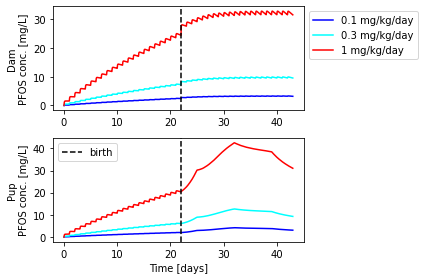

In [4]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21 # 21 days for lactation
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
    'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact'
]
final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': 0,         # Start simulation at conception
    'tf': t_gest+t_lact, 
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_step':0.001,
    'sex': 'Male',          
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':0,         # Start maternal dosing at conception (GD0)
    't_m_end': t_gest+t_lact,      # End maternal dosing on 20 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 0.1,             # 0 mg/kg dose
    'M_m_1': 0.268,
    'M_m_2': 0.365,
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.3, M_m_1=0.267, M_m_2=0.363)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1, M_m_1=0.266, M_m_2=0.351)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
#test_PFOS.ax[1].set_ylim(1e0, 1e2)
#test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Butenhoff et al, 2009')

### Lau et al., 2003

Dose to dam from GD2 to GD21 with oral gavage. Study tracked infants to PND35 for tox endpoints. Run simulation to t_lact for end of lactation

Running developmental model
current adult dose 1
current infant dose 0
Running developmental model
current adult dose 2
current infant dose 0
Running developmental model
current adult dose 3
current infant dose 0
Running developmental model
current adult dose 5
current infant dose 0
Running developmental model
current adult dose 10
current infant dose 0


,1 mg/kg,2 mg/kg,3 mg/kg,5 mg/kg,10 mg/kg
Cmax_dam,25.407702,50.815404,76.223105,127.038506,254.077003
Cavg_dam,12.480471,24.960942,37.441413,62.402354,124.804706
AUCavg_dam_gest,12.480399,24.960798,37.441197,62.401995,124.803988
AUCavg_dam_lact,16.576262,33.152523,49.728783,82.881302,165.762594
AUCavg_dam_gest_lact,14.481041,28.962081,43.443122,72.405201,144.810395
Cavg_pup_gest,10.395743,20.791486,31.187228,51.978714,103.957425
Cmax_pup_gest,19.795879,39.591758,59.387637,98.979394,197.958782
Cavg_pup_lact,24.505966,49.011932,73.517897,122.529825,245.059638
Cmax_pup_lact,29.955433,59.910865,89.866296,149.777157,299.554298
Cavg_pup_gest_lact,17.286782,34.573564,51.860346,86.433908,172.867808


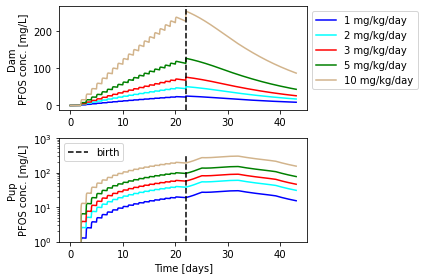

In [5]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21 # 21 days for lactation
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact']
final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': 0,         # Start simulation at conception
    'tf': t_gest+t_lact,     # 22 days of gestation plus  21 days post-partum
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_step':0.001,
    'sex': 'Male',           
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':2,         # Start maternal dosing at conception (GD0)
    't_m_end': 21,      # End maternal dosing on GD21 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 1,             # 0 mg/kg dose
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=2)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=3)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=5)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=10)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='tan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
test_PFOS.ax[1].set_ylim(1e0, 1e3)
test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Lau et al., 2003')

### Li et al., 2016

Expose dam from GD12-GD18

Running developmental model
current adult dose 5
current infant dose 0
Running developmental model
current adult dose 20
current infant dose 0


,5 mg/kg,20 mg/kg
Cmax_dam,44.636945,178.547777
Cavg_dam,14.652001,58.608003
AUCavg_dam_gest,14.651558,58.606231
AUCavg_dam_lact,28.760781,115.043116
AUCavg_dam_gest_lact,21.542610,86.170435
Cavg_pup_gest,12.204002,48.816008
Cmax_pup_gest,37.182575,148.730298
Cavg_pup_lact,42.521318,170.085261
Cmax_pup_lact,51.976623,207.906481
Cavg_pup_gest_lact,27.010133,108.040527


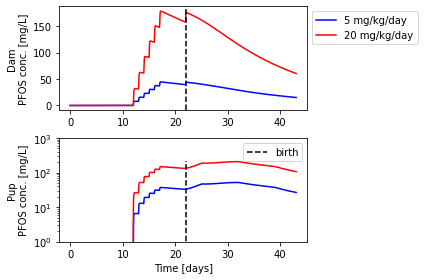

In [6]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21 # 21 days for lactation
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact']
final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': 0,         # Start simulation at conception
    'tf': t_gest+t_lact,     # 22 days of gestation plus  21 days post-partum
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_step':0.001,
    'sex': 'Male',           
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':12,         # Start maternal dosing at conception (GD0)
    't_m_end': 18,      # End maternal dosing on GD21 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 5,             # 0 mg/kg dose
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=20)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
test_PFOS.ax[1].set_ylim(1e0, 1e3)
test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Li et al., 2016')

### Zhang, 2019

Expose Dam from GD1 - PND90 in drinking water. Then expose pup in drinking water from PND21 to PND90

Running developmental model
current adult dose 0.25
current infant dose 0.25
Running developmental model
current adult dose 0.72
current infant dose 0.72
Running developmental model
current adult dose 2.17
current infant dose 2.17


,0.25 mg/kg,0.72 mg/kg,2.17 mg/kg
Cmax_dam,5.579923,16.070179,48.433733
Cavg_dam,1.999780,5.759368,17.358094
AUCavg_dam_gest,1.999736,5.759238,17.357704
AUCavg_dam_lact,6.576722,18.940960,57.085948
AUCavg_dam_gest_lact,4.235107,12.197107,36.760725
Cavg_pup_gest,1.665682,4.797163,14.458116
Cmax_pup_gest,4.318911,12.438463,37.488144
Cavg_pup_lact,7.336693,21.129675,63.682493
Cmax_pup_lact,8.875110,25.560316,77.035952
Cavg_pup_gest_lact,4.435245,12.773506,38.497928


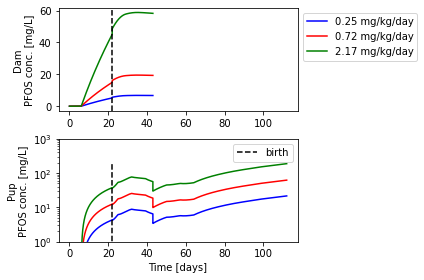

In [7]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21 # 21 days for lactation
tf = t_gest+90
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact', 
               'Css_pup_wean', 'Cmax_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'
              ]
final_metrics = []
dosing_dict = {    
    'chem': 'PFOS',
    'ts': 0,         # Start simulation at conception
    'tf': tf,     # PNW19
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.999,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Male',           
    'sex_i': 'Female',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 0.25,          # 150 ppm --> mg/kg dose to dam
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': tf,      # End maternal dosing on 21 days post-partum

    'dose_i': 0.25,       # 300 ppm --> mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': tf,
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.72, dose_i=0.72)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=2.17, dose_i=2.17)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
test_PFOS.ax[1].set_ylim(1e0, 1e3)
test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Zhang et al., 2019')

## Reproductive

### Luebker et al, 2005 (1)

42d prior mating-LD20

Running developmental model
current adult dose 0.1
current infant dose 0
Running developmental model
current adult dose 0.4
current infant dose 0
Running developmental model
current adult dose 1.6
current infant dose 0
Running developmental model
current adult dose 3.2
current infant dose 0


,0.1 mg/kg,0.4 mg/kg,1.6 mg/kg,3.2 mg/kg
Cmax_dam,4.960248,19.844911,79.416706,177.714015
Cavg_dam,4.616131,18.383545,73.931798,157.241434
AUCavg_dam_gest,9.798384,39.117147,156.884481,323.073384
AUCavg_dam_lact,4.680782,18.681451,75.066974,180.102939
AUCavg_dam_gest_lact,7.361605,29.386563,117.926571,316.871055
Cavg_pup_gest,3.845225,15.313447,61.584990,130.981340
Cmax_pup_gest,4.131887,16.530811,66.154116,135.444139
Cavg_pup_lact,5.808527,23.121471,93.079485,139.587023
Cmax_pup_lact,6.968995,27.732098,111.658256,146.715531
Cavg_pup_gest_lact,4.780131,19.031554,76.582369,131.355500


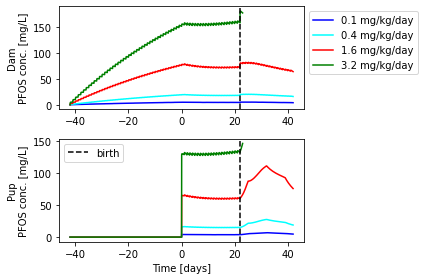

In [8]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 20 # 20 days for lactation
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact']
final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': -42,         # Start simulation 42 days before conception
    'tf': t_gest+t_lact, 
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_step':0.001,
    'sex': 'Male',           
    't_gest': t_gest,
    't_lact': t_lact,
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':-42,         # Start maternal dosing 42 days before conception
    't_m_end': t_gest+t_lact,      # End maternal dosing on 20 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 0.1,             # 0.1 mg/kg dose
    'M_m_1': 0.236,
    'M_m_2': 0.326,
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.4, M_m_1=0.237, M_m_2=0.332)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1.6, M_m_1=0.238, M_m_2=0.329)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

t_lact = 1 # Only 1 day into lactation
test_PFOS.update_p(dose=3.2, M_m_1=0.236, M_m_2=0.273, t_lact=t_lact, tf=t_gest+t_lact, t_m_end=t_gest+t_lact)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
#test_PFOS.ax[1].set_ylim(1e0, 1e2)
#test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Luebker et al, 2005 (1)')

### Luebker et al, 2005 (2)

56d - Sires exposed 56 days before mating

Simply run the adult Wambaugh et al. model

Running adult model for rat with 0.1 mg/kg PFOS
Running adult model for rat with 0.4 mg/kg PFOS
Running adult model for rat with 1.6 mg/kg PFOS
Running adult model for rat with 3.2 mg/kg PFOS


,0.1 mg/kg,0.4 mg/kg,1.6 mg/kg,3.2 mg/kg
C7avg,5.933477,23.700323,94.724526,188.906565
AUC,196.396116,784.797395,3137.390100,6262.056148
Cavg,3.510256,14.026937,56.075539,111.923329
Cmax,6.198432,24.757417,98.946688,197.307028
AUCavg,3.507074,14.014239,56.024823,111.822431


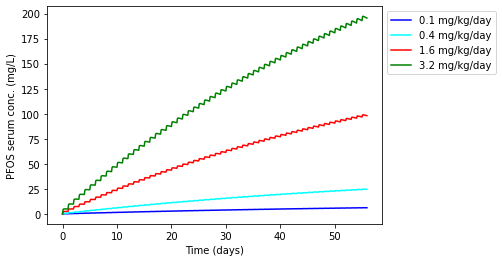

In [9]:
# Dictionary for dosing-specific parameters
dev_metrics = [
    'C7avg', 'AUC', 'Cavg', 'Cmax', 'AUCavg']
final_metrics = []
dosing_dict = {'chem': 'PFOS',
                   'tf': 56,
                   'sex': 'Male',
                   'route': 'oral',
                   'strain': 'rat',
                   'M_m_1': np.mean([.390,.539]),
                   'Qcc': 12.39,
                   't_dose': 0.003,
                   'dose': 0.1,     # Oral gavage dose applied over ~5 minutes
                   'tm_daily_dose': [0], # Once daily
                   't_m_start': 0,
                   't_m_end': 56,
                   #'tm_daily_dose': None, # None -> one dose
                   'sample_posterior': False,
                   'param_path': param_path,
                   'model_path': model_path,
                   'dev': False,
                   }

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.4, M_m_1=np.mean([.390,.523]))
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1.6, M_m_1=np.mean([.391, .513]))
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=3.2, M_m_1=np.mean([.391, .482]))
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

#test_PFOS.ax[1].set_ylim(1e0, 1e2)
#test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Luebker et al, 2005 (2)')

### Luebker et al, 2005 (3)

76d (42d pre-cohabitation, 14d mating, GD0-20)

Running developmental model
current adult dose 1.6
current infant dose 0
Running developmental model
current adult dose 2
current infant dose 0


,1.6 mg/kg,2 mg/kg
Cmax_dam,82.915123,103.643902
Cavg_dam,79.906075,99.882592
AUCavg_dam_gest,171.388221,214.235274
Cavg_pup_gest,66.561709,83.202135
Cmax_pup_gest,69.068298,86.335370
AUCavg_pup_gest,66.561806,83.202256


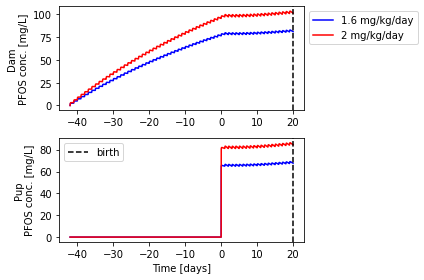

In [10]:
# Dictionary for dosing-specific parameters
t_gest = 20 # 20 days of gestation
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest',
    'Cavg_pup_gest', 'Cmax_pup_gest', 
              'AUCavg_pup_gest']
final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': -42,         # Start simulation 42 days before conception
    'tf': t_gest+0.001, 
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_step':0.001,
    'sex': 'Male',           # Dams are Female
    't_gest': t_gest,
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':-42,         # Start maternal dosing 42 days before conception
    't_m_end': t_gest,      # End maternal dosing on 20 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 1.6,             # 0.1 mg/kg dose
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=2)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
#test_PFOS.ax[1].set_ylim(1e0, 1e2)
#test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Luebker et al, 2005 (3)')

### Luebker et al, 2005 (4)

80d (42d pre-mating, GD0-21, LD1-4)

Running developmental model
current adult dose 0.4
current infant dose 0
Running developmental model
current adult dose 0.8
current infant dose 0
Running developmental model
current adult dose 1.0
current infant dose 0
Running developmental model
current adult dose 1.2
current infant dose 0
Running developmental model
current adult dose 1.6
current infant dose 0
Running developmental model
current adult dose 2
current infant dose 0


,0.4 mg/kg,0.8 mg/kg,1.0 mg/kg,1.2 mg/kg,1.6 mg/kg,2 mg/kg
Cmax_pre,19.272751,38.545501,48.181876,57.818250,77.090999,96.363748
AUCavg_pre,10.856736,21.713472,27.141839,32.570207,43.426943,54.283678
Cmax_dam,19.840993,39.681986,49.602482,59.522978,79.363970,99.204961
Cavg_dam,18.464525,36.929049,46.161311,55.393573,73.858096,92.322618
AUCavg_dam_gest,39.193534,78.387066,97.983832,117.580598,156.774129,195.967658
AUCavg_dam_lact,20.269039,40.538077,50.672596,60.807115,81.076151,101.345187
AUCavg_dam_gest_lact,36.283468,72.566936,90.708669,108.850402,145.133868,181.417333
Cavg_pup_gest,15.380899,30.761798,38.452248,46.142697,61.523594,76.904492
Cmax_pup_gest,16.527547,33.055094,41.318868,49.582641,66.110187,82.637733
Cavg_pup_lact,18.947894,37.895788,47.369734,56.843680,75.791572,94.739463


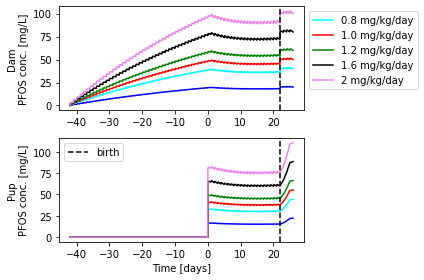

In [11]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 4 # 4 days for lactation
dev_metrics = ['Cmax_pre', 'AUCavg_pre',
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact']
final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': -42,         # Start simulation 42 days before conception
    'tf': t_gest+t_lact, 
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_step':0.001,
    'sex': 'Male',           # Dams are Female
    't_gest': t_gest,
    't_lact': t_lact,
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':-42,         # Start maternal dosing 42 days before conception
    't_m_end': t_gest+t_lact,      # End maternal dosing on 20 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 0.4,             # 0.1 mg/kg dose
    'M_m_1': 0.236,
    'M_m_2': 0.326,
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.8)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1.)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1.2)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1.6)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='black', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=2)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='violet', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
#test_PFOS.ax[1].set_ylim(1e0, 1e2)
#test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Luebker et al, 2005 (4)')

### Luebker et al, 2005 (5) - Male

GD0-PND112 for male offspring

Running developmental model
current adult dose 0.1
current infant dose 0.1
Running developmental model
current adult dose 0.4
current infant dose 0.4


,0.1 mg/kg,0.4 mg/kg
Cmax_dam,2.900699,11.602795
Cavg_dam,1.483481,5.933923
AUCavg_dam_gest,1.483475,5.933902
AUCavg_dam_lact,3.111750,12.446999
AUCavg_dam_gest_lact,2.278732,9.114929
Cavg_pup_gest,1.235686,4.942743
Cmax_pup_gest,2.208330,8.833320
Cavg_pup_lact,3.622818,14.491272
Cmax_pup_lact,4.398116,17.592463
Cavg_pup_gest_lact,2.401495,9.605978


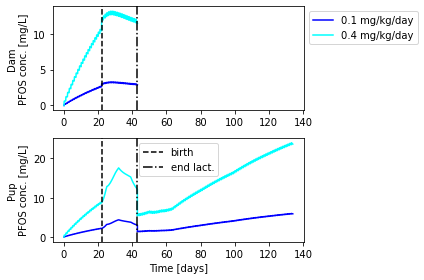

In [12]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21
t_f = t_gest + 112 # PND 112
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact',
        'Cmax_pup_wean', 'Css_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'
]

final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_lact': 21,
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_dose_i': 0.003,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Male',           # Dams are Female
    'sex_i': 'Male',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 0.1,          # 0.1 mg/kg dose to dam
    't_m_start':0,         # Start maternal dosing on GD0
    't_m_end': t_gest+t_lact,      # End maternal dosing on 21 days post-partum
    

    'dose_i': 0.1,       # 0.1 mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': t_f,

    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.4, dose_i=0.4)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))


final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)

test_PFOS.add_features(disp_birth=True, disp_lact=True)
final_metrics.to_excel(writer, sheet_name='Luebker et al, 2005 (5) - M')

### Luebker et al, 2005 (5) - Female

GD0-PND112 for Female offspring

This one is tricky... Don't currently have capability to two pregnancies

Running developmental model
current adult dose 0.1
current infant dose 0.1
Running developmental model
current adult dose 0.4
current infant dose 0.4


,0.1 mg/kg,0.4 mg/kg
Cmax_dam,2.900699,11.602795
Cavg_dam,1.483481,5.933923
AUCavg_dam_gest,1.483475,5.933902
AUCavg_dam_lact,3.111750,12.446999
AUCavg_dam_gest_lact,2.278732,9.114929
Cavg_pup_gest,1.235686,4.942743
Cmax_pup_gest,2.208330,8.833320
Cavg_pup_lact,3.622818,14.491272
Cmax_pup_lact,4.398116,17.592463
Cavg_pup_gest_lact,2.401495,9.605978


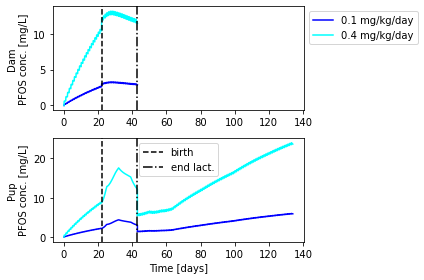

In [13]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21
t_f = t_gest + 112 # PND 112
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact',
        'Cmax_pup_wean', 'Css_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'
]

final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_lact': 21,
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_dose_i': 0.003,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Male',           # Dams are Female
    'sex_i': 'Male',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 0.1,          # 0.1 mg/kg dose to dam
    't_m_start':0,         # Start maternal dosing on GD0
    't_m_end': t_gest+t_lact,      # End maternal dosing on 21 days post-partum
    

    'dose_i': 0.1,       # 0.1 mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': t_f,

    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.4, dose_i=0.4)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))


final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)

test_PFOS.add_features(disp_birth=True, disp_lact=True)
final_metrics.to_excel(writer, sheet_name='Luebker et al, 2005 (5) - F')

### Luebker et al, 2005 (6) 

GD0-PND21
**Skipping for now because it's F2 generation**

### Luebker et al, 2005 (7) 

GD0-PND4

Running developmental model
current adult dose 0.4
current infant dose 0
Running developmental model
current adult dose 0.8
current infant dose 0
Running developmental model
current adult dose 1
current infant dose 0
Running developmental model
current adult dose 1.2
current infant dose 0
Running developmental model
current adult dose 1.6
current infant dose 0
Running developmental model
current adult dose 2
current infant dose 0


,0.4 mg/kg,0.8 mg/kg,1 mg/kg,1.2 mg/kg,1.6 mg/kg,2 mg/kg
Cmax_dam,11.602795,23.205590,29.006988,34.808385,46.411180,58.013975
Cavg_dam,5.933923,11.867846,14.834808,17.801769,23.735692,29.669615
AUCavg_dam_gest,5.933902,11.867803,14.834754,17.801705,23.735607,29.669508
AUCavg_dam_lact,12.430961,24.861923,31.077403,37.292884,49.723845,62.154806
AUCavg_dam_gest_lact,6.933716,13.867432,17.334290,20.801148,27.734864,34.668580
Cavg_pup_gest,4.942743,9.885487,12.356858,14.828230,19.770973,24.713716
Cmax_pup_gest,8.833320,17.666639,22.083299,26.499958,35.333278,44.166597
Cavg_pup_lact,11.050854,22.101709,27.627136,33.152563,44.203417,55.254271
Cmax_pup_lact,13.128817,26.257634,32.822042,39.386451,52.515267,65.644084
Cavg_pup_gest_lact,5.882453,11.764905,14.706132,17.647358,23.529811,29.412263


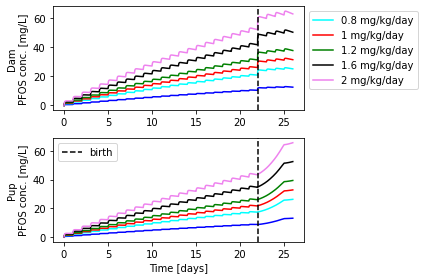

In [14]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 4 # 4 days for lactation (PND4)
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact']
final_metrics = []
dosing_dict = {
    'chem': 'PFOS',
    'ts': 0,         # Start simulation at conception
    'tf': t_gest+t_lact, 
    't_dose': 0.003,     # Oral gavage dose applied over ~5 minutes
    't_step':0.001,
    'sex': 'Male',           # Dams are Female
    't_gest': t_gest,
    't_lact': t_lact,
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':0,         # Start maternal dosing at conception
    't_m_end': t_gest+t_lact,      # End maternal dosing on 20 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 0.4,             # 0.1 mg/kg dose
    
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOS = PFAS_DR(**dosing_dict)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='blue')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=0.8)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1.2)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=1.6)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='black', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.update_p(dose=2)
test_PFOS.run_model()
test_PFOS.plot_time_course(linestyle='-', color='violet', label_style='dose')
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics))

test_PFOS.add_features(disp_birth=True)
#test_PFOS.ax[1].set_ylim(1e0, 1e2)
#test_PFOS.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Luebker et al, 2005 (7)')

In [16]:
writer.save()

# PFOA Rat

In [17]:
writer = pd.ExcelWriter('internal_dose_metrics_RAT_DevRepro_PFOA_FINAL.xlsx', engine='xlsxwriter')

## Developmental

### NTP 2020

#### Example maternal dosing simulations

Dams are dosed from GD6 to LD21. Assume all exposure in pups comes from the maternal lactational exposure and there is **no** direct PFOA exposure to pups

For *t < t_lact*, there is no difference in model betweeen Male and Female pups

*Example* below demonstrating a gestation/lactation simulation

Running developmental model
current adult dose 0
current infant dose 0
Running developmental model
current adult dose 10.9
current infant dose 0
Running developmental model
current adult dose 21.7
current infant dose 0


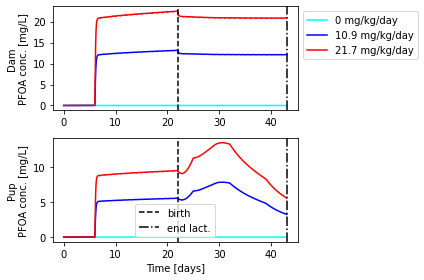

In [15]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_f = 21 # LD21

dosing_dict = {
    'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': t_gest+t_f,     # 22 days of gestation plus  21 days post-partum
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': 22+21,      # End maternal dosing on 21 days post-partum
    'route': 'oral',       # Oral route of exposure
    'dose': 0,             # 0 mg/kg dose
    'tm_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='cyan')

test_PFOA.update_p(dose=10.9)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='blue')

test_PFOA.update_p(dose=21.7)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='red')

test_PFOA.add_features(disp_birth=True, disp_lact=True)

*Example* simulation below of life-course modeling. 
1. Times prior to dahsed line represent concentrations during *gestation*. During this time, the Wambuagh model is used to simulate dam (F0) concentrations and `r_f_m` calculates a correspondning fetal (F1) concentration.
2. Time between the dashed and dot-dashed lines represent *lactation*. During this time, the Wambaugh model simulates dam (F0) concentrations while the one-compartment model simulates pup (F1) concentrations with first-order transfer of PFOS/PFOA through the milk.
3. Times greater than the dot-dashed line represents the *post-weaning* phase where the pup (F1) transitions to a juvenile and is modeled using the Wambaugh model with appropriate body weights. During this time, the dam (F0) concentrations are no longer tracked.

Running developmental model
current adult dose 10
current infant dose 10


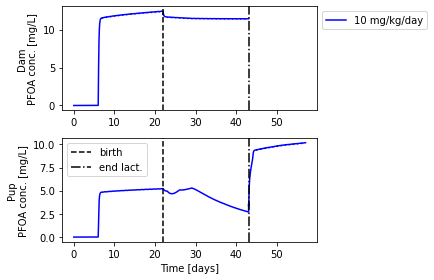

In [16]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation

t_f = 7*5+t_gest # PNW19
#t_f = 2*365 # 2 years
pup_150_300 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_150-300')
dosing_dict = {
    'growth_data': pup_150_300, # Reported pup weights from NTP study
    
    'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.999,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Female',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 10,          # 150 ppm --> mg/kg dose to dam
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': 22+21,      # End maternal dosing on 21 days post-partum
    'M_m_1': 0.27,         # Initial Dam weight
    'M_m_2': 0.281,         # Final Dam weight (post-partum)

    'dose_i': 10,       # 300 ppm --> mg/kg dose to pup
    't_i_start': 22+21,
    't_i_end': t_f,
    
    # Female infant weights during lactation (Table )
    'M_i_1': 0.00687,     # Infant mass 1 (kg).
    'M_i_2': 0.00956,      # Infant mass 2 (kg).
    'M_i_3': 0.01466,      # Infant mass 3 (kg).
    'M_i_4': 0.04868,       # Infant mass 4 (kg).
    
    't_i_1': 1,          # Time (d) since birth for infant mass 1.
    't_i_2': 4,         # Time (d) since birth for infant mass 2.
    't_i_3': 7,         # Time (d) since birth for infant mass 3.
    't_i_4': 21,         # Time (d) since birth for infant mass 4.
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='blue', label='dose')
test_PFOA.add_features(disp_birth=True, disp_lact=True)

#### Female offspring 2-year study (study 1)

Dams are dosed from GD6 to LD21. Before LD21, pups get exposure through lactation. After LD21, pups become "adults" and continue dosing through feed.

For *t < t_lact*, there is no difference in model betweeen Male and Female pups

**With and without perinatal expsoure with post-weaning in diet**

Simulate dam exposure at 0 ppm, 150 ppm, and 300 ppm followed by female pup exposure to 300 ppm and 1000 ppm following weaning

150/300:
* 150 ppm to dam: 10.9 mg/kg
* 300 ppm to pup: 29.6 mg/kg

300/1000:
* 300 ppm to dam: 18.4 mg/kg (PNW107 value)
* 1000 ppm to pup: 63.5 mg/kg (PNW107 value)

0/300:
* 0 ppm to dam
* 300 ppm to pup: 18.4 mg/kg

0/1000:
* 0 ppm to dam
* 1000 ppm to pup: 63.5 mg/kg

Running developmental model
current adult dose 0
current infant dose 18.4
Running developmental model
current adult dose 0
current infant dose 63.5
Running developmental model
current adult dose 10.9
current infant dose 18.4
Running developmental model
current adult dose 18.4
current infant dose 63.5


,0ppm/300ppm,0ppm/1000ppm,150ppm/300ppm,300ppm/1000ppm
Cmax_dam,0.000000,0.000000,13.294774,19.945340
Cavg_dam,0.000000,0.000000,9.263281,13.938428
AUCavg_dam_gest,0.000000,0.000000,9.263424,13.938643
AUCavg_dam_lact,0.000000,0.000000,12.294278,18.534512
AUCavg_dam_gest_lact,0.000000,0.000000,10.743858,16.183514
Cavg_pup_gest,0.000000,0.000000,3.890511,5.854040
Cmax_pup_gest,0.000000,0.000000,5.583805,8.377043
Cavg_pup_lact,0.000000,0.000000,4.525820,6.817387
Cmax_pup_lact,0.000000,0.000000,5.663363,8.532879
Cavg_pup_gest_lact,0.000000,0.000000,4.200778,6.324512


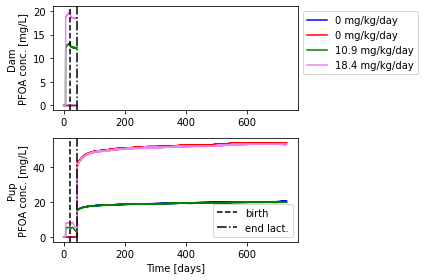

In [17]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21

dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact',
'Cmax_pup_wean', 'Css_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'

]

#t_f = 7*19+t_gest # PNW19
t_f = 2*365 # 2 years
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_0-300')
final_metrics = []
dosing_dict = {
    'growth_data': pup_growth, # Reported pup weights from NTP study
    
    'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.999,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Female',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 0,          # 0 ppm --> mg/kg dose to dam
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': t_gest+t_lact,      # End maternal dosing on 21 days post-partum
    'M_m_1': 0.27,         # Initial Dam weight
    'M_m_2': 0.281,         # Final Dam weight (post-partum)

    'dose_i': 18.4,       # 300 ppm --> mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': t_f,
    
    # Female infant weights during lactation (Table )
    'M_i_1': 0.00687,     # Infant mass 1 (kg).
    'M_i_2': 0.00956,      # Infant mass 2 (kg).
    'M_i_3': 0.01466,      # Infant mass 3 (kg).
    'M_i_4': 0.04868,       # Infant mass 4 (kg).
    
    't_i_1': 1,          # Time (d) since birth for infant mass 1.
    't_i_2': 4,         # Time (d) since birth for infant mass 2.
    't_i_3': 7,         # Time (d) since birth for infant mass 3.
    't_i_4': 21,         # Time (d) since birth for infant mass 4.
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

# 0/300
test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='blue', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='0ppm/300ppm'))
#test_PFOA.plot_data([16*7+t_gest], [20.8], lifestage='pup', color='blue')

#0/1000
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_0-1000')
test_PFOA.update_p(dose=0, dose_i=63.5, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='red', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='0ppm/1000ppm'))
#test_PFOA.plot_data([16*7+t_gest], [70.16], lifestage='pup', color='red')

#150/300
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_150-300')
test_PFOA.update_p(dose=10.9, dose_i=18.4, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='green', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='150ppm/300ppm'))
#test_PFOA.plot_data([16*7+t_gest], [70.16], lifestage='pup', color='red')

#300/1000
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_300-1000')
test_PFOA.update_p(dose=18.4, dose_i=63.5, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='violet', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='300ppm/1000ppm'))
#test_PFOA.plot_data([16*7+t_gest], [70.16], lifestage='pup', color='red')
test_PFOA.add_features(disp_birth=True, disp_lact=True)
#test_PFOA.add_features(disp_birth=True, disp_lact=True)
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='NTP 2 year (F)')

#### Male offspring 2-year study

Dams are dosed from GD6 to LD21. Before LD21, pups get exposure through lactation. After LD21, pups become "adults" and continue dosing through feed.

For *t < t_lact*, there is no difference in model betweeen Male and Female pups

**With and withou perinatal expsoure with post-weaning in diet**

Simulate dam exposure at 150 ppm and 300 ppm followed by male pup exposure to 150 ppm and 300 ppm following weaning

0/20:
* 0 ppm to dam
* 20 ppm to pup: 1.1 mg/kg

0/40:
* 0 ppm to dam
* 40 ppm to pup: 2.2 mg/kg

0/80:
* 0 ppm to dam
* 80 ppm to pup: 4.6 mg/kg

300/0:
* 300 ppm to dam: 21.7 mg/kg
* 0 ppm to pup

300/20:
* 300 ppm to dam: 21.7 mg/kg
* 20 ppm to pup: 1.1 mg/kg

300/40:
* 300 ppm to dam: 21.7 mg/kg
* 40 ppm to pup: 2.2 mg/kg

300/80:
* 300 ppm to dam: 21.7 mg/kg
* 80 ppm to pup: 4.6 mg/kg

Running developmental model
current adult dose 0
current infant dose 1.1
Running developmental model
current adult dose 0
current infant dose 2.2
Running developmental model
current adult dose 0
current infant dose 4.6
Running developmental model
current adult dose 21.7
current infant dose 0
Running developmental model
current adult dose 21.7
current infant dose 1.1
Running developmental model
current adult dose 21.7
current infant dose 2.2
Running developmental model
current adult dose 21.7
current infant dose 4.6


,0ppm/20ppm,0ppm/40ppm,0ppm/80ppm,300ppm/0ppm,300ppm/20ppm,300ppm/40ppm,300ppm/80ppm
Cmax_dam,0.000000,0.000000,0.000000,2.275112e+01,22.751117,22.751117,22.751117
Cavg_dam,0.000000,0.000000,0.000000,1.590106e+01,15.901065,15.901065,15.901065
AUCavg_dam_gest,0.000000,0.000000,0.000000,1.590131e+01,15.901312,15.901312,15.901312
AUCavg_dam_lact,0.000000,0.000000,0.000000,2.112963e+01,21.129626,21.129626,21.129626
AUCavg_dam_gest_lact,0.000000,0.000000,0.000000,1.845510e+01,18.455104,18.455104,18.455104
Cavg_pup_gest,0.000000,0.000000,0.000000,6.678334e+00,6.678334,6.678334,6.678334
Cmax_pup_gest,0.000000,0.000000,0.000000,9.555469e+00,9.555469,9.555469,9.555469
Cavg_pup_lact,0.000000,0.000000,0.000000,7.467924e+00,7.467924,7.467924,7.467924
Cmax_pup_lact,0.000000,0.000000,0.000000,9.532787e+00,9.532787,9.532787,9.532787
Cavg_pup_gest_lact,0.000000,0.000000,0.000000,7.063948e+00,7.063948,7.063948,7.063948


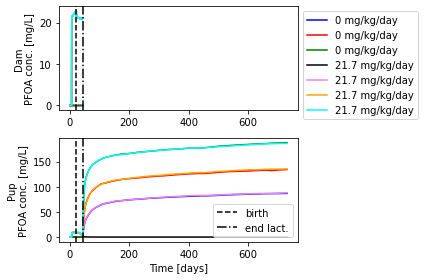

In [18]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21

dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact',
'Cmax_pup_wean', 'Css_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'

]
final_metrics = []
#t_f = 7*19+t_gest # PNW19
t_f = 2*365 # 2 years

pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-20')
dosing_dict = {
    'growth_data': pup_growth, # Reported pup weights from NTP study
    
    'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.999,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Male',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 0,          # 150 ppm --> mg/kg dose to dam
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': t_gest+t_lact,      # End maternal dosing on 21 days post-partum
    'M_m_1': 0.27,         # Initial Dam weight
    'M_m_2': 0.281,         # Final Dam weight (post-partum)

    'dose_i': 1.1,       # 150 ppm --> mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': t_f,
    
    # Male infant weights during lactation (Table 9)
    'M_i_1': 0.0071,     # Infant mass 1 (kg).
    'M_i_2': 0.01013,      # Infant mass 2 (kg).
    'M_i_3': 0.01542,      # Infant mass 3 (kg).
    'M_i_4': 0.05061,       # Infant mass 4 (kg).
    
    't_i_1': 1,          # Time (d) since birth for infant mass 1.
    't_i_2': 4,         # Time (d) since birth for infant mass 2.
    't_i_3': 7,         # Time (d) since birth for infant mass 3.
    't_i_4': 21,         # Time (d) since birth for infant mass 4.
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

# 0/20
test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='blue', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='0ppm/20ppm'))

# 0/40
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-40')
test_PFOA.update_p(dose=0, dose_i=2.2, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='red', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='0ppm/40ppm'))

# 0/80
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-80')
test_PFOA.update_p(dose=0, dose_i=4.6, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='green', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='0ppm/80ppm'))

# 300/0
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-0')
test_PFOA.update_p(dose=21.7, dose_i=0, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='black', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='300ppm/0ppm'))

# 300/20
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-20')
test_PFOA.update_p(dose=21.7, dose_i=1.1, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='violet', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='300ppm/20ppm'))

# 300/40
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-40')
test_PFOA.update_p(dose=21.7, dose_i=2.2, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='orange', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='300ppm/40ppm'))

# 300/80
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-80')
test_PFOA.update_p(dose=21.7, dose_i=4.6, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(label_style='dose', linestyle='-', color='cyan', label='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics, name='300ppm/80ppm'))

test_PFOA.add_features(disp_birth=True, disp_lact=True)
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='NTP 2 year (M)')

## Reproductive

### Butenhoff (1)

64d - Male exposure

Assume initial weight of 170 g (weight at 6 weeks)

Running adult model for rat with 1 mg/kg PFOA
Running adult model for rat with 3 mg/kg PFOA
Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA


,1 mg/kg,3 mg/kg,10 mg/kg,30 mg/kg
C7avg,61.975360,137.915759,222.426083,232.867974
AUC,2907.443390,6916.283345,12201.684235,13463.653941
Cavg,45.354580,107.805379,189.589114,206.584006
Cmax,65.731334,147.841792,253.860250,299.582686
AUCavg,45.428803,108.066927,190.651316,210.369593


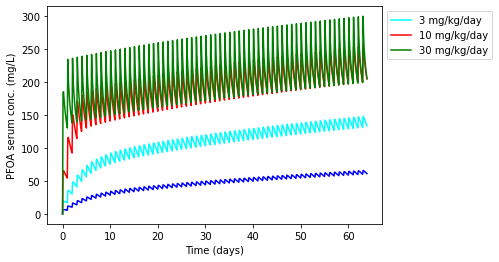

In [19]:
# Dictionary for dosing-specific parameters
dev_metrics = [
    'C7avg', 'AUC', 'Cavg', 'Cmax', 'AUCavg']
final_metrics = []
tf=64
dosing_dict = {'chem': 'PFOA',
                   'tf': tf,
                   'sex': 'Male',
                   'route': 'oral',
                   'strain': 'rat',
                   'adult_growth': True,
                   'M_m_1': 0.17,
                   'M_m_2': 0.575,
                   't_m_1': 0,
                   't_m_2': tf,
                   'Qcc': 12.39,
                   't_dose': 0.003,
                   'dose': 1,     # Oral gavage dose applied over ~5 minutes
                   'tm_daily_dose': [0], # Once daily
                   't_m_start': 0,
                   't_m_end': tf,
                   #'tm_daily_dose': None, # None -> one dose
                   'sample_posterior': False,
                   'param_path': param_path,
                   'model_path': model_path,
                   'dev': False,
                   'adult_growth': True
                   }

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='blue')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=3, M_m_2=0.542)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=10, M_m_2=0.513)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=30, M_m_2=0.432)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

#test_PFOA.ax[1].set_ylim(1e0, 1e2)
#test_PFOA.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Butenhoff (1)')

### Butenhoff (2)

84d - Female exposure

Assume initial weight of 154 g (weight at 6 weeks)

Running adult model for rat with 1 mg/kg PFOA
Running adult model for rat with 3 mg/kg PFOA
Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA


,1 mg/kg,3 mg/kg,10 mg/kg,30 mg/kg
C7avg,1.442436,3.527753,8.573238,20.993814
AUC,91.979880,231.513081,599.831625,1538.213636
Cavg,1.251531,3.063597,7.559487,18.665772
Cmax,5.110526,13.757632,39.428138,109.849762
AUCavg,1.437186,3.617392,9.372369,24.034588


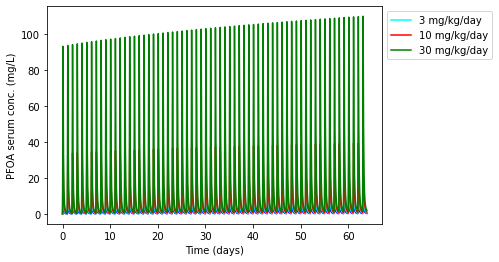

In [20]:
# Dictionary for dosing-specific parameters
dev_metrics = [
    'C7avg', 'AUC', 'Cavg', 'Cmax', 'AUCavg']
final_metrics = []
tf=64
dosing_dict = {'chem': 'PFOA',
                   'tf': tf,
                   'sex': 'Female',
                   'route': 'oral',
                   'strain': 'rat',
                   'adult_growth': True,
                   'M_m_1': 0.154,
                   'M_m_2': 0.340,
                   't_m_1': 0,
                   't_m_2': tf,
                   'Qcc': 12.39,
                   't_dose': 0.003,
                   'dose': 1,     # Oral gavage dose applied over ~5 minutes
                   'tm_daily_dose': [0], # Once daily
                   't_m_start': 0,
                   't_m_end': tf,
                   #'tm_daily_dose': None, # None -> one dose
                   'sample_posterior': False,
                   'param_path': param_path,
                   'model_path': model_path,
                   'dev': False,
                   'adult_growth': True
                   }

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='blue')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=3, M_m_2=0.351)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=10, M_m_2=0.342)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=30, M_m_2=0.345)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

#test_PFOA.ax[1].set_ylim(1e0, 1e2)
#test_PFOA.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Butenhoff (2)')

### Butenhoff (3)

GD0-PND120 - Male exposure

Running developmental model
current adult dose 1
current infant dose 1
Running developmental model
current adult dose 3
current infant dose 3
Running developmental model
current adult dose 10
current infant dose 10
Running developmental model
current adult dose 30
current infant dose 30


,1 mg/kg,3 mg/kg,10 mg/kg,30 mg/kg
Cmax_dam,6.140933,17.317191,53.806672,156.044091
Cavg_dam,1.528392,3.788275,9.817275,25.089870
AUCavg_dam_gest,1.528394,3.788280,9.817289,25.089900
AUCavg_dam_lact,1.490767,3.718384,9.670189,24.708528
AUCavg_dam_gest_lact,1.510053,3.754232,9.745676,24.904227
Cavg_pup_gest,0.641924,1.591075,4.123255,10.537744
Cmax_pup_gest,2.579192,7.273220,22.598802,65.538518
Cavg_pup_lact,0.737945,1.838371,4.778006,12.210795
Cmax_pup_lact,1.014631,2.545290,6.683729,17.254284
Cavg_pup_gest_lact,0.688818,1.711847,4.443017,11.354815


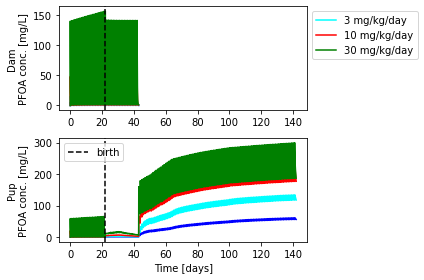

In [21]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21
tf = 120+t_gest
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact',
'Cmax_pup_wean', 'Css_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'

]
final_metrics = []
dosing_dict = {
   'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': tf,     # PNW19
    't_dose': 0.003,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.003,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Male',         # Pups are Male
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 1,          # 150 ppm --> mg/kg dose to dam
    't_m_start':0,         # Start maternal dosing on GD6
    't_m_end': t_gest+t_lact,      # End maternal dosing on 21 days post-partum

    'dose_i': 1,       # 150 ppm --> mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': tf,
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='blue')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=3, dose_i=3)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=10, dose_i=10)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=30, dose_i=30)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))


test_PFOA.add_features(disp_birth=True)
#test_PFOA.ax[1].set_ylim(1e0, 1e2)
#test_PFOA.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Butenhoff (3)')

### Butenhoff (4)

GD0-PND127 - Female exposure

Running developmental model
current adult dose 1
current infant dose 1
Running developmental model
current adult dose 3
current infant dose 3
Running developmental model
current adult dose 10
current infant dose 10
Running developmental model
current adult dose 30
current infant dose 30


,1 mg/kg,3 mg/kg,10 mg/kg,30 mg/kg
Cmax_dam,6.140933,17.317191,53.806672,156.044091
Cavg_dam,1.528392,3.788275,9.817275,25.089870
AUCavg_dam_gest,1.528394,3.788280,9.817289,25.089900
AUCavg_dam_lact,1.490767,3.718384,9.670189,24.708528
AUCavg_dam_gest_lact,1.510053,3.754232,9.745676,24.904227
Cavg_pup_gest,0.641924,1.591075,4.123255,10.537744
Cmax_pup_gest,2.579192,7.273220,22.598802,65.538518
Cavg_pup_lact,0.737945,1.838371,4.778006,12.210795
Cmax_pup_lact,1.014631,2.545290,6.683729,17.254284
Cavg_pup_gest_lact,0.688818,1.711847,4.443017,11.354815


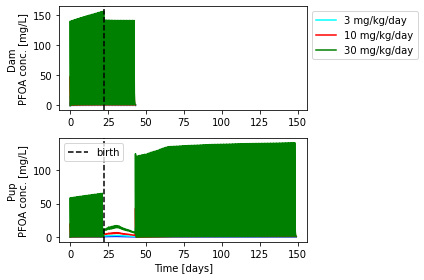

In [22]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21
tf = 127+t_gest
dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact',
'Cmax_pup_wean', 'Css_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'

]
final_metrics = []
dosing_dict = {
   'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': tf,     # PNW19
    't_dose': 0.003,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.003,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Female',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 1,          # 150 ppm --> mg/kg dose to dam
    't_m_start':0,         # Start maternal dosing on GD6
    't_m_end': t_gest+t_lact,      # End maternal dosing on 21 days post-partum

    'dose_i': 1,       # 150 ppm --> mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': tf,
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    
}

#'M_m_1': 0.268 # Initial maternal weight
#'M_m_2': 0.365 # Post-partum maternal weight
    
test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='blue')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=3, dose_i=3)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='cyan', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=10, dose_i=10)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='red', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))

test_PFOA.update_p(dose=30, dose_i=30)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='green', label_style='dose')
final_metrics.append(test_PFOA.get_internal_dose_metrics(dev_metrics))


test_PFOA.add_features(disp_birth=True)
#test_PFOA.ax[1].set_ylim(1e0, 1e2)
#test_PFOA.ax[1].set_yscale('log')
final_metrics = pd.concat(final_metrics, axis=1)
display(final_metrics)
final_metrics.to_excel(writer, sheet_name='Butenhoff (4)')

In [25]:
writer.save()